In [1]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

from funciones import plot_silhouette
from funciones import plot_silhouettes_and_sses
from funciones import get_silhouette_avg
from funciones import get_sse
from funciones import vanDongen

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE

from umap import UMAP

Para realizar un clustering espectral, se toman los resultados de aplicarle UMAP al dataset y luego, al resultado, se le aplica KMeans.

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

In [4]:
metadata = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis = pd.read_csv('../data/audio_analysis.csv', index_col='id')

audio_features = audio_features[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

# Para que las comparaciones sean del mismo largo,
# se remueve de audio_feature y metadata el track que no se encuentra en audio_analysis
merged = audio_features.merge(audio_analysis, how = 'left', on = 'id')
id_to_remove = merged[merged.timbre_mean_0.isnull()].index[0]

audio_features = audio_features.drop(id_to_remove, axis = 0)

audio_tracks = pd.merge(audio_features, audio_analysis, how = 'inner', on = 'id')
metadata = metadata.drop(id_to_remove, axis = 0)

# Se ordenan los datasets para que los tracks estén en el mismo orden
audio_features = audio_features.sort_index()
audio_analysis = audio_analysis.sort_index()
audio_tracks = audio_tracks.sort_index()
metadata = metadata.sort_index()

audio_features_norm = scaler.fit_transform(audio_features)
audio_analysis_norm = scaler.fit_transform(audio_analysis)
audio_tracks_norm = scaler.fit_transform(audio_tracks)

In [5]:
genres = []
for genre in metadata.genre:
    if genre == 'ambient':
        genres.append(0)
    if genre == 'classical':
        genres.append(1)
    if genre == 'drum-and-bass':
        genres.append(2)
    if genre == 'jazz':
        genres.append(3)
    if genre == 'world-music':
        genres.append(4)
len(genres)

2205

# audio_features

In [5]:
# Se le aplica UMAP al audio_features_norm
um = UMAP()
embedding = um.fit_transform(audio_features_norm)
embedding.shape

/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


(2205, 2)

Se busca un k óptimo para clusterizar las 2 dimensiones obtenidas con UMAP.

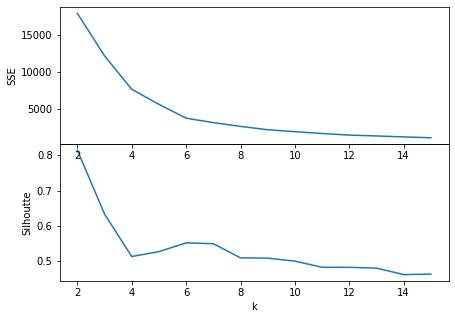

In [6]:
plot_silhouettes_and_sses(embedding, 15)

Parece que se tiene un buen tradeoff con k = 6, que es donde el SSE toma la forma de codo y el silhouette levanta por sobre 0.5.

In [7]:
get_silhouette_avg(embedding, 6)

0.5521191

In [8]:
get_sse(embedding, 6)

3790.0994547732284

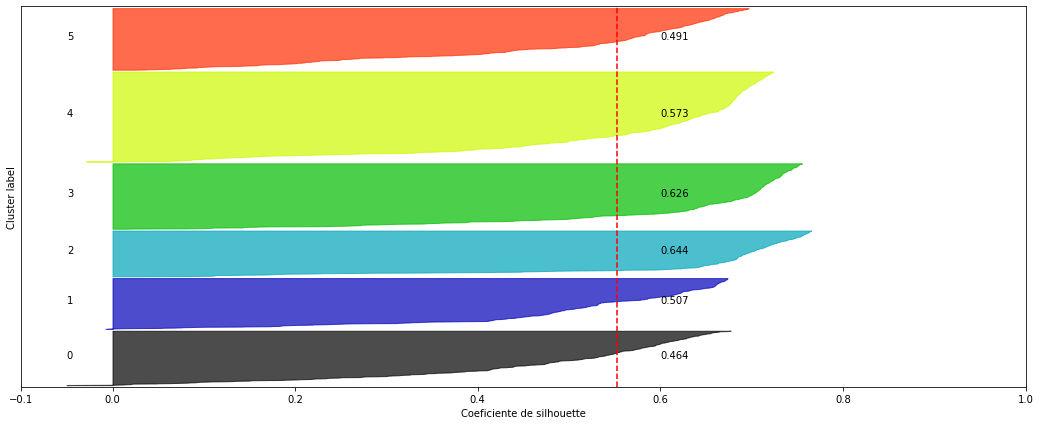

In [9]:
plot_silhouette(embedding, 6)

Se evalua qué tan buenos son los agrupamientos obtenidos.

In [10]:
km_audio_features = KMeans(n_clusters = 6, random_state = 0).fit(embedding)

In [11]:
# Se calcula la matriz de confusión
tmp1 = pd.DataFrame({'Generos': metadata.genre, 'audio_features': km_audio_features.labels_})
ct1 = pd.crosstab(tmp1['Generos'], tmp1['audio_features'])
ct1

audio_features,0,1,2,3,4,5
Generos,,,,,,
ambient,44,37,10,154,189,26
classical,0,0,27,126,197,55
drum-and-bass,226,220,1,0,0,4
jazz,17,17,98,72,89,133
world-music,39,31,138,40,64,151


In [12]:
vanDongen(ct1)

0.7124413145539906

In [13]:
adjusted_rand_score(metadata.genre, km_audio_features.labels_)

0.18817222667347086

# Hiperparametrización

UMAP tiene varios hiperparámetros para probar. Se prueba optimizar los siguientes parámetros de UMAP con algunos valores:

 * n_neighbors
 * min_dist
 * n_components
 * metrics
 
Junto con los 3 datasets, los 2 distintos scalers y k de 2 a 15 inclusive.

In [ ]:
# OPTIMIZACIÓN 1: Alcanzado con 500 iteraciones y minimizando el índice de rand ajustado
# {'components': 4.0, 'dataset': 2, 'k': 3.0, 'metric': 1, 'min_d': 0, 'neighbors': 9.0, 'scaler': 1}

In [6]:
df = audio_tracks
metric = "manhattan"
scaler = StandardScaler()
components = 4
k = 3
min_d = 0
neighbors = 9

# Se estandariza usando el scaler correspondiente
df = scaler.fit_transform(df)
                            
# Se aplica UMAP
um = UMAP(n_components = components, n_neighbors = neighbors, min_dist = min_d, metric = metric)
embedding = um.fit_transform(df)
                            
# Se aplica KMeans al embedding
km = KMeans(n_clusters = k, random_state = 0).fit(embedding)
                            
# Se calcula la matriz de confusion
tmp = pd.DataFrame({'Generos': metadata.genre, 'data': km.labels_})
ct = pd.crosstab(tmp['Generos'], tmp['data'])
             
# Se aplica Van Dongen
vanDongen(ct)

0.434386193422338

In [7]:
ct

data,0,1,2
Generos,,,
ambient,37,343,80
classical,1,390,14
drum-and-bass,442,2,7
jazz,8,58,360
world-music,31,83,349


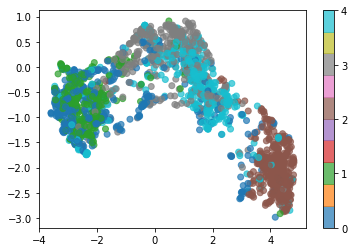

In [8]:
genres = []
for genre in metadata.genre:
    if genre == 'ambient':
        genres.append(0)
    if genre == 'classical':
        genres.append(1)
    if genre == 'drum-and-bass':
        genres.append(2)
    if genre == 'jazz':
        genres.append(3)
    if genre == 'world-music':
        genres.append(4)

plt.scatter(embedding[:,0],embedding[:,1],
            c = genres, cmap = plt.cm.tab10, alpha=0.7)
plt.colorbar(ticks=range(6));

In [9]:
adjusted_rand_score(metadata.genre, km.labels_)

0.397909984863417

In [10]:
get_silhouette_avg(embedding, k)

0.56574124

In [11]:
get_sse(embedding, k)

2920.874885787499

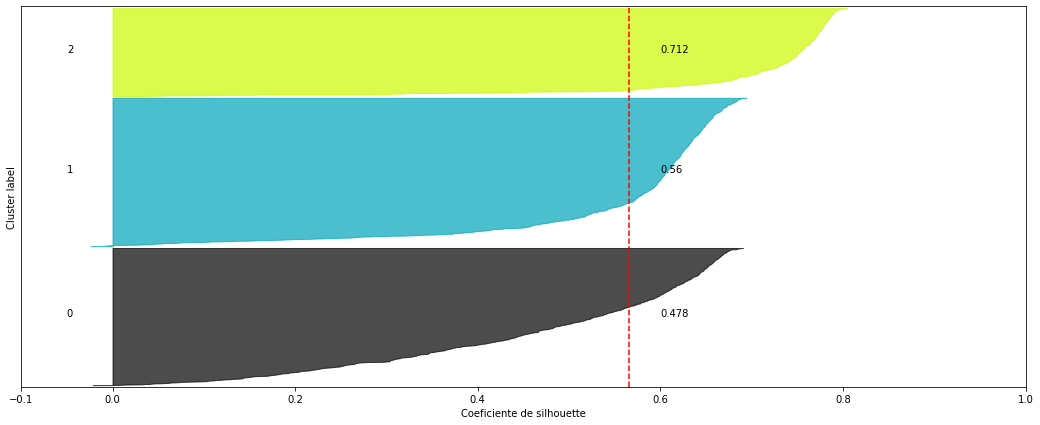

In [12]:
plot_silhouette(embedding, k)

([6803.491293830687,
  2920.874885787499,
  2249.061663628522,
  1904.2057604637646,
  1645.1888112234797,
  1435.9832379941413,
  1285.5502962926173,
  1171.2009858382958,
  1071.3409267036511,
  996.4785586217745,
  926.1459188733907,
  874.0195812412605,
  819.5427629048422,
  780.1228626501892],
 [0.5322705,
  0.56574124,
  0.48253846,
  0.40258372,
  0.42604566,
  0.39706323,
  0.40982407,
  0.4082163,
  0.33564192,
  0.33157814,
  0.3495388,
  0.34749794,
  0.3456515,
  0.33978269])

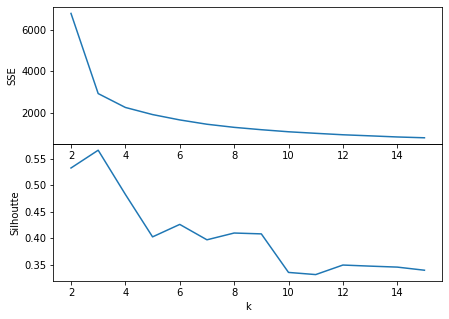

In [13]:
plot_silhouettes_and_sses(embedding, 15)

In [14]:
# OPTIMIZACIÓN 2: Alcanzado con 500 iteraciones y minimizando van Dongen
# {'components': 5.0, 'dataset': 2, 'k': 3.0, 'metric': 3, 'min_d': 0, 'neighbors': 50.0, 'scaler': 0}

In [15]:
df = audio_tracks
metric = "canberra"
scaler = MinMaxScaler(feature_range=(0,1))
components = 5
k = 3
min_d = 0
neighbors = 50

# Se estandariza usando el scaler correspondiente
df = scaler.fit_transform(df)
                            
# Se aplica UMAP
um = UMAP(n_components = components, n_neighbors = neighbors, min_dist = min_d, metric = metric)
embedding = um.fit_transform(df)
                            
# Se aplica KMeans al embedding
km = KMeans(n_clusters = k, random_state = 0).fit(embedding)
                            
# Se calcula la matriz de confusion
tmp = pd.DataFrame({'Generos': metadata.genre, 'data': km.labels_})
ct = pd.crosstab(tmp['Generos'], tmp['data'])
             
# Se aplica Van Dongen
vanDongen(ct)

0.4448030987734022

In [22]:
ct

data,0,1,2
Generos,,,
ambient,321,28,111
classical,381,2,22
drum-and-bass,1,440,10
jazz,53,10,363
world-music,85,35,343


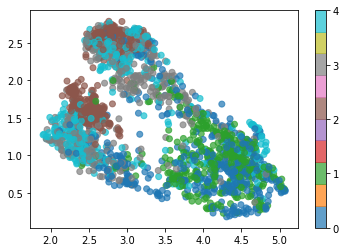

In [16]:
genres = []
for genre in metadata.genre:
    if genre == 'ambient':
        genres.append(0)
    if genre == 'classical':
        genres.append(1)
    if genre == 'drum-and-bass':
        genres.append(2)
    if genre == 'jazz':
        genres.append(3)
    if genre == 'world-music':
        genres.append(4)

plt.scatter(embedding[:,0],embedding[:,1],
            c = genres, cmap = plt.cm.tab10, alpha=0.7)
plt.colorbar(ticks=range(6));

In [17]:
adjusted_rand_score(metadata.genre, km.labels_)

0.3780914190523075

In [18]:
get_silhouette_avg(embedding, k)

0.5265447

In [19]:
get_sse(embedding, k)

2070.596462522637

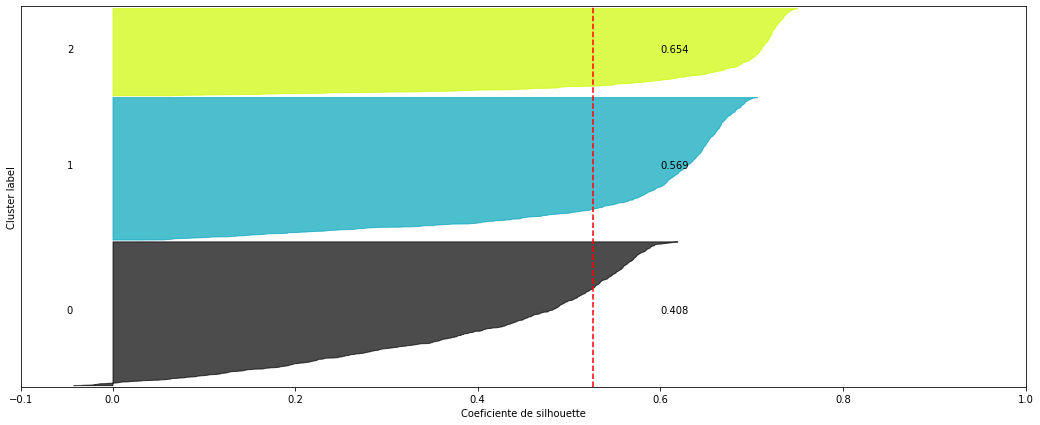

In [20]:
plot_silhouette(embedding, k)

([4358.159563516655,
  2070.596462522637,
  1642.0663300721292,
  1334.308692319694,
  1207.4983741695594,
  1090.1142761806764,
  994.0248749838568,
  906.705500603297,
  820.0686954310864,
  748.2043513014798,
  693.148672773339,
  654.8890147495429,
  620.0004669618813,
  592.3987451237194],
 [0.511442,
  0.5265447,
  0.4381765,
  0.45742318,
  0.40771425,
  0.33878312,
  0.32455406,
  0.3320054,
  0.3292601,
  0.33585358,
  0.34321168,
  0.33359563,
  0.33527678,
  0.32358328])

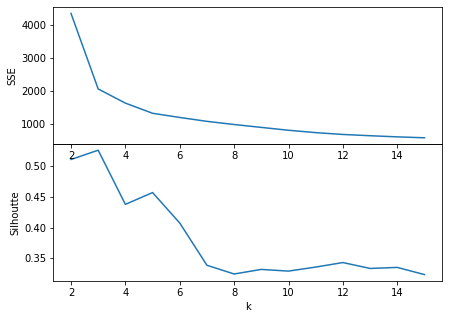

In [21]:
plot_silhouettes_and_sses(embedding, 15)